<a href="https://colab.research.google.com/github/kkkaeun/AImodel/blob/main/AImodel_240701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Conv1D, Concatenate
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras import layers

from tensorflow.python.framework.ops import disable_eager_execution
tf.compat.v1.keras.backend.clear_session()
disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
df_Course = pd.read_csv('/content/sample_data/120115_robot/ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS = pd.read_csv('/content/sample_data/120115_robot/nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])
total_timestamps = len(df_GPS)
window_size = 40
start_point = 5
num_windows = total_timestamps - window_size + 1 - start_point

df = df_GPS.iloc[start_point:total_timestamps]
data = df[['North', 'East']]

df_Accel = pd.read_csv('/content/sample_data/120115_robot/nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df = df_Accel.iloc[start_point:total_timestamps]
data['Accel_x_NED'] = df['Accel_x_NED']
data['Accel_y_NED'] = df['Accel_y_NED']
data['Accel_z_NED'] = df['Accel_z_NED']

df_Euler = pd.read_csv('/content/sample_data/120115_robot/nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df = df_Euler.iloc[start_point:total_timestamps]
data['Euler_x'] = df['Euler_x']
data['Euler_y'] = df['Euler_y']
data['Euler_z'] = df['Euler_z']

df = df_Course.iloc[start_point:total_timestamps]
data['Gyro_x'] = df['Gyro_x']
data['Gyro_y'] = df['Gyro_y']
data['Gyro_z'] = df['Gyro_z']
data

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
5,-2.529000e-22,-1.880200e-07,-0.015457,-0.061172,9.8135,-10.253,0.017555,0.12345,-0.003942,-0.017728,0.008630
6,-1.917000e-22,-1.425300e-07,-0.016796,-0.062033,9.8136,-10.225,0.009961,0.11810,-0.000898,-0.022419,0.008681
7,-1.122300e-22,-8.344200e-08,-0.017110,-0.062197,9.8139,-10.212,0.008394,0.11676,-0.003350,-0.031966,0.007079
8,-2.262700e-23,-1.682300e-08,-0.017660,-0.062160,9.8142,-10.227,0.007397,0.11370,-0.003208,-0.032875,-0.005021
9,6.897500e-23,5.128200e-08,-0.018273,-0.062871,9.8145,-10.240,0.002218,0.11194,-0.001454,-0.038174,-0.011122
...,...,...,...,...,...,...,...,...,...,...,...
320091,-1.686400e+00,-2.496800e+00,-0.142280,-0.011752,9.8092,-135.810,0.006030,-0.67141,-0.004698,0.000619,-0.008716
320092,-1.686400e+00,-2.496800e+00,-0.141650,-0.011759,9.8092,-135.820,0.007374,-0.66800,-0.002714,-0.005613,-0.001590
320093,-1.686300e+00,-2.496800e+00,-0.141660,-0.012048,9.8092,-135.810,0.005780,-0.66744,-0.001513,-0.004799,0.004491
320094,-1.686100e+00,-2.496800e+00,-0.140300,-0.013310,9.8093,-135.800,0.001955,-0.65727,-0.002847,-0.013433,0.005820


In [ ]:
#정답 레이블을 위한 GPS 변화량 데이터 만들기
delta_data = data.diff(axis=0)
delta_North = delta_data['North']
delta_East = delta_data['East']

shifted = delta_data[['North', 'East']].copy()

shifted['Pred_N'] = shifted['North'].shift(-window_size)
shifted['Pred_E'] = shifted['East'].shift(-window_size)

shifted.fillna(method='ffill', inplace = True)
shifted.tail()

,North,East,Pred_N,Pred_E
320091,0.0000,0.0000,0.0003,0.0001
320092,0.0000,0.0000,0.0003,0.0001
320093,0.0001,0.0000,0.0003,0.0001
320094,0.0002,0.0000,0.0003,0.0001
320095,0.0003,0.0001,0.0003,0.0001


In [ ]:
train_X = data[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED',  'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X = train_X.astype(np.float32)

shifted_train_X = {}

for i in range(1, window_size + 1):
    shifted_X = train_X.shift(-i)
    shifted_X.fillna(method='ffill', inplace=True)
    shifted_train_X[f'train_X{i}'] = shifted_X

shifted_train_X['train_X40'].tail()

,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
320091,-0.139,-0.016845,9.8093,-135.779999,-0.014323,-0.64249,-0.002012,-0.008011,0.00869
320092,-0.139,-0.016845,9.8093,-135.779999,-0.014323,-0.64249,-0.002012,-0.008011,0.00869
320093,-0.139,-0.016845,9.8093,-135.779999,-0.014323,-0.64249,-0.002012,-0.008011,0.00869
320094,-0.139,-0.016845,9.8093,-135.779999,-0.014323,-0.64249,-0.002012,-0.008011,0.00869
320095,-0.139,-0.016845,9.8093,-135.779999,-0.014323,-0.64249,-0.002012,-0.008011,0.00869


In [ ]:
train_y=shifted[['Pred_N', 'Pred_E']][:num_windows]

x_data = train_X[:num_windows].values
x_data = np.array(x_data)
x_data = x_data.reshape(-1, 1, 9)
y_data = train_y.values

print(x_data.shape)
print(y_data.shape)

(320052, 1, 9)
(320052, 2)


In [ ]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

sc = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d = x_data.reshape(-1, x_data.shape[-1])
y_data_2d = y_data.reshape(-1, y_data.shape[-1])

# 스케일링 적용
new_x_data_2d = sc.fit_transform(x_data_2d)
new_y_data_2d = sc.fit_transform(y_data_2d)

# 다시 3D로 변환
new_x_data = new_x_data_2d.reshape(x_data.shape)
new_y_data = new_y_data_2d.reshape(y_data.shape)

# train-test split
x_train, x_val, y_train, y_val = train_test_split(new_x_data, new_y_data, test_size=0.33, shuffle=True, random_state=42)

print(new_x_data.shape)
print(new_y_data.shape)
print(x_train.shape)

(320052, 1, 9)
(320052, 2)
(214434, 1, 9)


In [ ]:
x_train_array = []
for i in range(1, window_size + 1):
    x = np.roll(x_train, shift=-i, axis=0)
    x[:i] = x_train[-1]
    x_train_array.append(x)

x_val_array = []
for i in range(1, window_size + 1):
    x = np.roll(x_val, shift=-i, axis=0)
    x[:i] = x_val[-1]
    x_val_array.append(x)

In [ ]:
from tensorflow.keras import backend as K


def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.

    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.

    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.

    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.

    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.

    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

In [ ]:
    # Number of training samples.
    sample_count = x_train.shape[0]

    # Total epochs to train.
    epochs = 200

    # Number of warmup epochs.
    warmup_epoch = 10

    # Training batch size, set small value here for demonstration purpose.
    batch_size = 64

    # Base learning rate after warmup.
    learning_rate_base = 0.0001

    total_steps = int(epochs * sample_count / batch_size)

    # Compute the number of warmup batches.
    warmup_steps = int(warmup_epoch * sample_count / batch_size)

    # Compute the number of warmup batches.
    warmup_batches = warmup_epoch * sample_count / batch_size

    # Create the Learning rate scheduler.
    warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                            total_steps=total_steps,
                                            warmup_learning_rate=0.0,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=0)


In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling1D, TimeDistributed

def Single_model():
  input_layers = []
  cnn_layers = []

  for i in range(1, 41):
      visible = Input(shape=(1, 9))
      input_layers.append(visible)

      x = Conv1D(filters=64, kernel_size=1, padding="causal", activation="relu", strides=1)(visible)
      x = Conv1D(filters=128, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
      x = Conv1D(filters=256, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
      x = Conv1D(filters=512, kernel_size=1, padding="causal", activation="relu", strides=1)(x)
      cnn_layers.append(x)

  x = Concatenate(axis=1)(cnn_layers)
  x = GRU(40, activation="tanh", return_sequences=False)(x)
  x = Dropout(0.25)(x)
  output = Dense(2, activation="linear")(x)

  model = Model(inputs=input_layers, outputs=output)
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
  model.summary()

  return model

if __name__ == "__main__":
    model = Single_model()

    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

    history = model.fit(x_train_array, y_train, batch_size = batch_size, epochs=epochs, validation_data=(x_val_array, y_val), callbacks=[warm_up_lr])

    model.save('my_model.h5')

    y_pred = model.predict(x_val_array)


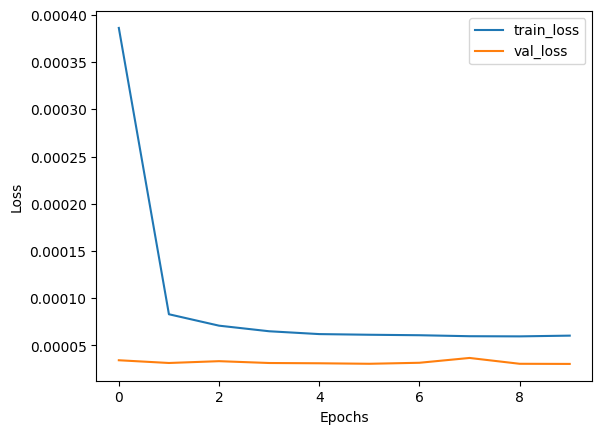

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred[:,0,:]

array([[ 0.04976842, -0.0047522 ],
       [ 0.04975909, -0.00475624],
       [ 0.04977765, -0.00476931],
       ...,
       [ 0.0496983 , -0.00499531],
       [ 0.0497933 , -0.00474211],
       [ 0.04970648, -0.00475583]], dtype=float32)

**TEST 1. 120122 NCLT robot data**

**예측 구간: 53020 ~ 56020 (30s)**

**곡선구간1 (좌회전)**

In [ ]:
df_Course1 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST1 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])

TEST1_timestamps = 3040
window_size_TEST1 = 40
start_point_TEST1 = 53000
num_windows_TEST1 = TEST1_timestamps - window_size_TEST1 + 1

df_TEST1 = df_GPS_TEST1.iloc[start_point_TEST1:start_point_TEST1 + TEST1_timestamps]
data_TEST1 = df_TEST1[['North', 'East']]

df_Accel_TEST1 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST1 = df_Accel_TEST1.iloc[start_point_TEST1:start_point_TEST1 + TEST1_timestamps]
data_TEST1['Accel_x_NED'] = df_TEST1['Accel_x_NED']
data_TEST1['Accel_y_NED'] = df_TEST1['Accel_y_NED']
data_TEST1['Accel_z_NED'] = df_TEST1['Accel_z_NED']

df_Euler_TEST1 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST1 = df_Euler_TEST1.iloc[start_point_TEST1:start_point_TEST1 + TEST1_timestamps]
data_TEST1['Euler_x'] = df_TEST1['Euler_x']
data_TEST1['Euler_y'] = df_TEST1['Euler_y']
data_TEST1['Euler_z'] = df_TEST1['Euler_z']

df_TEST1 = df_Course1.iloc[start_point_TEST1:start_point_TEST1 + TEST1_timestamps]
data_TEST1['Gyro_x'] = df_TEST1['Gyro_x']
data_TEST1['Gyro_y'] = df_TEST1['Gyro_y']
data_TEST1['Gyro_z'] = df_TEST1['Gyro_z']
data_TEST1.tail()

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
56035,-2.7489,-8.6936,-0.45030,-0.82132,9.7650,-166.07,-5.0707,0.58416,-0.004568,-0.017415,0.052479
56036,-2.7491,-8.6933,-0.45141,-0.82915,9.7632,-165.96,-5.1125,0.60581,-0.001193,-0.013934,0.044516
56037,-2.7493,-8.6929,-0.44680,-0.84511,9.7623,-165.82,-5.1724,0.68256,0.008228,-0.013311,0.046475
56038,-2.7495,-8.6926,-0.44323,-0.85158,9.7632,-165.75,-5.1903,0.72162,0.014156,-0.019513,0.043979
56039,-2.7497,-8.6923,-0.43776,-0.85976,9.7652,-165.66,-5.2091,0.77554,0.021529,-0.023156,0.039751


In [ ]:
delta_data_TEST1 = data_TEST1.diff(axis=0)
delta_North_TEST1 = delta_data_TEST1['North']
delta_East_TEST1 = delta_data_TEST1['East']

shifted_TEST1 = delta_data_TEST1[['North', 'East']].copy()
shifted_TEST1['Pred_N'] = shifted_TEST1['North'].shift(-window_size_TEST1)
shifted_TEST1['Pred_E'] = shifted_TEST1['East'].shift(-window_size_TEST1)

shifted_TEST1['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST1['Pred_E'].fillna(method='ffill', inplace = True)

In [ ]:
train_X_TEST1 =  data_TEST1[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST1 = train_X_TEST1.astype(np.float32)

train_y_TEST1 = shifted_TEST1[['Pred_N', 'Pred_E']].astype(np.float32)[:num_windows_TEST1]

x_data_TEST1 = train_X_TEST1[:num_windows_TEST1].values
x_data_TEST1 = np.array(x_data_TEST1)
x_data_TEST1 = x_data_TEST1.reshape(-1, 1, 9)
y_data_TEST1 = train_y_TEST1.values

print(x_data_TEST1.shape)
print(y_data_TEST1.shape)

(3001, 1, 9)
(3001, 2)


In [ ]:
x_data_TEST1 = x_data_TEST1.astype(np.float32)
y_data_TEST1 = y_data_TEST1.astype(np.float32)

sc_TEST1 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST1 = x_data_TEST1.reshape(-1, x_data_TEST1.shape[-1])
y_data_2d_TEST1 = y_data_TEST1.reshape(-1, y_data_TEST1.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST1 = sc_TEST1.fit_transform(x_data_2d_TEST1)
new_y_data_2d_TEST1 = sc_TEST1.fit_transform(y_data_2d_TEST1)

# 다시 3D로 변환
new_x_data_TEST1 = new_x_data_2d_TEST1.reshape(x_data_TEST1.shape)
new_y_data_TEST1 = new_y_data_2d_TEST1.reshape(y_data_TEST1.shape)

print(new_x_data_TEST1.shape)
print(new_y_data_TEST1.shape)

TEST1_array = []
for i in range(1, window_size + 1):
    x = np.roll(new_x_data_TEST1, shift=-i, axis=0)
    x[:i] = new_x_data_TEST1[-1]
    TEST1_array.append(x)

(3001, 1, 9)
(3001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST1 = model.predict(TEST1_array)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST1 = np.array(y_pred_TEST1)
new_y_data_array_TEST1 = np.array(new_y_data_TEST1)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST1 = y_preds_array_TEST1.reshape(-1, y_preds_array_TEST1.shape[-1])
new_y_data_flat_TEST1 = new_y_data_array_TEST1.reshape(-1, new_y_data_array_TEST1.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST1 = sc_TEST1.inverse_transform(y_preds_flat_TEST1)
rescaled_y_test_actual_N_E_TEST1 = sc_TEST1.inverse_transform(new_y_data_flat_TEST1)

# 위도와 경도값만 가져오기
predicted_North_TEST1 = rescaled_y_preds_N_E_TEST1[:, 0]
predicted_East_TEST1 = rescaled_y_preds_N_E_TEST1[:, 1]

actual_North_TEST1 = rescaled_y_test_actual_N_E_TEST1[:, 0]
actual_East_TEST1 = rescaled_y_test_actual_N_E_TEST1[:, 1]

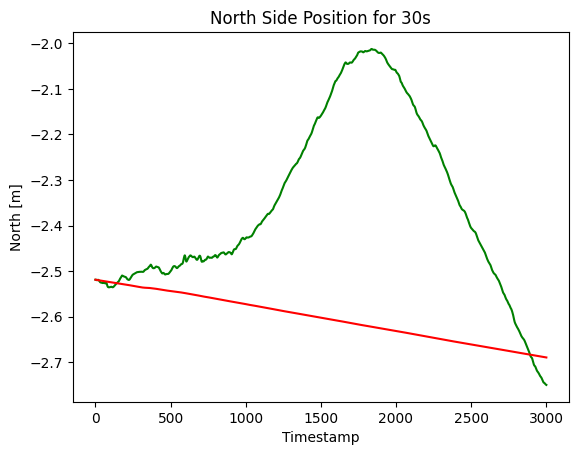

In [ ]:
# 초기값 설정
initial_North = data_TEST1['North'][53040]

# 실제 latitude 추정치 계산
North_predicted_TEST1 = [initial_North]
for change in predicted_North_TEST1:
    new_North_TEST1 = North_predicted_TEST1[-1] + change
    North_predicted_TEST1.append(new_North_TEST1)

# 실제 latitude 추정치 계산
North_actual_TEST1 = [initial_North]
for change in actual_North_TEST1:
    new_North_TEST1 = North_actual_TEST1[-1] + change
    North_actual_TEST1.append(new_North_TEST1)

# 시각화
plt.plot(North_actual_TEST1, label='Actual', c='g')
plt.plot(North_predicted_TEST1, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

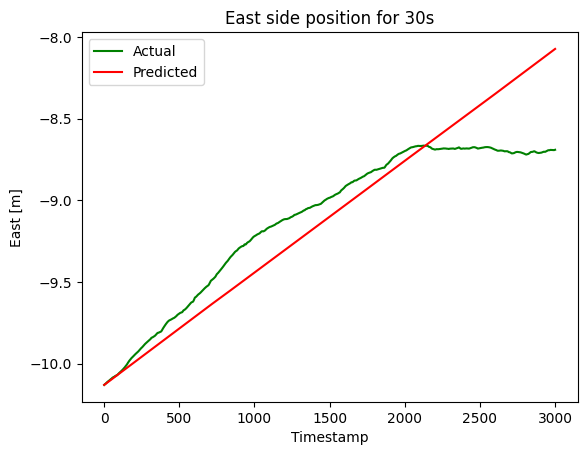

In [ ]:
# 초기값 설정
initial_East = data_TEST1['East'][53040]

# 실제 latitude 추정치 계산
East_predicted_TEST1 = [initial_East]
for change in predicted_East_TEST1:
    new_East_TEST1 = East_predicted_TEST1[-1] + change
    East_predicted_TEST1.append(new_East_TEST1)

# 실제 latitude 추정치 계산
East_actual_TEST1 = [initial_East]
for change in actual_East_TEST1:
    new_East_TEST1 = East_actual_TEST1[-1] + change
    East_actual_TEST1.append(new_East_TEST1)

# 시각화
plt.plot(East_actual_TEST1, label='Actual', c='g')
plt.plot(East_predicted_TEST1, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

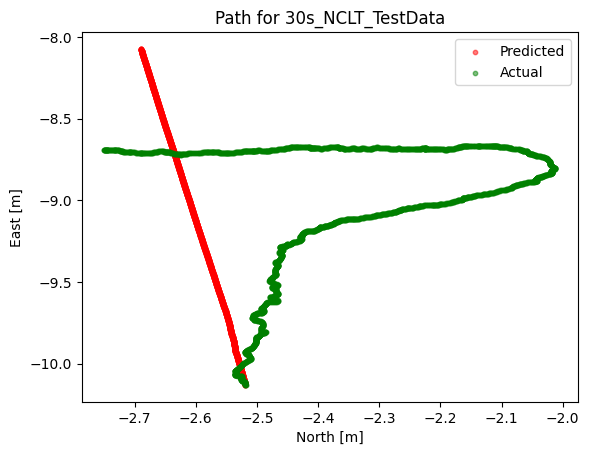

In [ ]:
plt.scatter(x=North_predicted_TEST1, y=East_predicted_TEST1, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST1, y=East_actual_TEST1, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

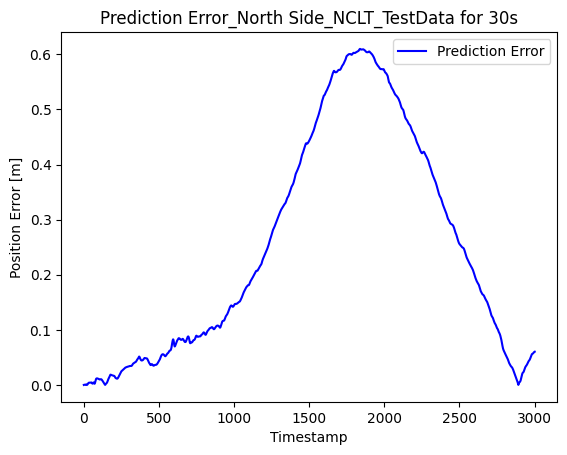

SE: 0.060 m
RMSE: 0.321 m


In [ ]:
East_actual_TEST1 = np.array(East_actual_TEST1)
North_actual_TEST1 = np.array(North_actual_TEST1)
East_predicted_TEST1 = np.array(East_predicted_TEST1)
North_predicted_TEST1 = np.array(North_predicted_TEST1)

SE_TEST1 = np.sqrt((North_actual_TEST1 - North_predicted_TEST1) ** 2)
RMSE_TEST1 = np.sqrt(np.mean((North_actual_TEST1 - North_predicted_TEST1) ** 2))

time_steps_TEST1 = np.arange(len(SE_TEST1))

plt.plot(time_steps_TEST1, SE_TEST1, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST1[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST1))

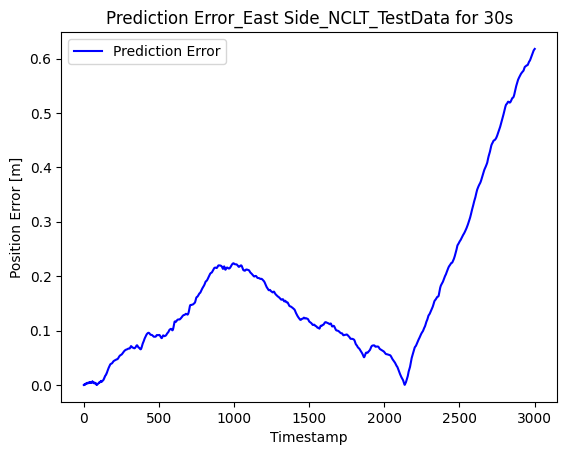

SE: 0.618 m
RMSE: 0.226 m


In [ ]:
SE_TEST1 = np.sqrt((East_actual_TEST1 - East_predicted_TEST1) ** 2)
RMSE_TEST1 = np.sqrt(np.mean((East_actual_TEST1 - East_predicted_TEST1) ** 2))

time_steps_TEST1 = np.arange(len(SE_TEST1))

plt.plot(time_steps_TEST1, SE_TEST1, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST1[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST1))

**TEST 2. 120122 NCLT robot data**

**예측 구간: 61020 ~ 64020 (30s)**

**직선구간1 (상하)**

In [ ]:
df_Course2 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])

TEST2_timestamps = 3040
window_size_TEST2 = 40
start_point_TEST2 = 61000
num_windows_TEST2 = TEST2_timestamps - window_size_TEST2 + 1

df_TEST2 = df_GPS_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2 = df_TEST2[['North', 'East']]

df_Accel_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST2 = df_Accel_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Accel_x_NED'] = df_TEST2['Accel_x_NED']
data_TEST2['Accel_y_NED'] = df_TEST2['Accel_y_NED']
data_TEST2['Accel_z_NED'] = df_TEST2['Accel_z_NED']

df_Euler_TEST2 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST2 = df_Euler_TEST2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Euler_x'] = df_TEST2['Euler_x']
data_TEST2['Euler_y'] = df_TEST2['Euler_y']
data_TEST2['Euler_z'] = df_TEST2['Euler_z']

df_TEST2 = df_Course2.iloc[start_point_TEST2:start_point_TEST2 + TEST2_timestamps]
data_TEST2['Gyro_x'] = df_TEST2['Gyro_x']
data_TEST2['Gyro_y'] = df_TEST2['Gyro_y']
data_TEST2['Gyro_z'] = df_TEST2['Gyro_z']
data_TEST2.head()

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
61000,-3.4716,-10.989,0.15923,0.18317,9.8085,111.22,1.7784,0.039095,0.130140,0.242588,-0.229709
61001,-3.4718,-10.991,0.25906,0.17203,9.8061,110.58,2.0667,0.550460,0.092341,0.212480,-0.185267
61002,-3.4719,-10.992,0.33886,0.18209,9.8030,110.09,2.3870,0.894710,0.072402,0.190063,-0.158077
61003,-3.4721,-10.993,0.43692,0.18337,9.7977,109.57,2.7285,1.356000,0.031135,0.155973,-0.132807
61004,-3.4722,-10.995,0.56469,0.19909,9.7894,108.91,3.2402,1.909900,-0.038900,0.084437,-0.085074


In [ ]:
delta_data_TEST2 = data_TEST2.diff(axis=0)
delta_North_TEST2 = delta_data_TEST2['North']
delta_East_TEST2 = delta_data_TEST2['East']

shifted_TEST2 = delta_data_TEST2[['North', 'East']].copy()
shifted_TEST2['Pred_N'] = shifted_TEST2['North'].shift(-window_size_TEST2)
shifted_TEST2['Pred_E'] = shifted_TEST2['East'].shift(-window_size_TEST2)

shifted_TEST2['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST2['Pred_E'].fillna(method='ffill', inplace = True)

In [ ]:
train_X_TEST2 =  data_TEST2[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST2 = train_X_TEST2.astype(np.float32)

train_y_TEST2 = shifted_TEST2[['Pred_N', 'Pred_E']].astype(np.float32)[:num_windows_TEST2]

x_data_TEST2 = train_X_TEST2[:num_windows_TEST2].values
x_data_TEST2 = np.array(x_data_TEST2)
x_data_TEST2 = x_data_TEST2.reshape(-1, 1, 9)
y_data_TEST2 = train_y_TEST2.values

print(x_data_TEST2.shape)
print(y_data_TEST2.shape)

(3001, 1, 9)
(3001, 2)


In [ ]:
x_data_TEST2 = x_data_TEST2.astype(np.float32)
y_data_TEST2 = y_data_TEST2.astype(np.float32)

sc_TEST2 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST2 = x_data_TEST2.reshape(-1, x_data_TEST2.shape[-1])
y_data_2d_TEST2 = y_data_TEST2.reshape(-1, y_data_TEST2.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST2 = sc_TEST2.fit_transform(x_data_2d_TEST2)
new_y_data_2d_TEST2 = sc_TEST2.fit_transform(y_data_2d_TEST2)

# 다시 3D로 변환
new_x_data_TEST2 = new_x_data_2d_TEST2.reshape(x_data_TEST2.shape)
new_y_data_TEST2 = new_y_data_2d_TEST2.reshape(y_data_TEST2.shape)

print(new_x_data_TEST2.shape)
print(new_y_data_TEST2.shape)

TEST2_array = []
for i in range(1, window_size + 1):
    x = np.roll(new_x_data_TEST2, shift=-i, axis=0)
    x[:i] = new_x_data_TEST2[-1]
    TEST2_array.append(x)

(3001, 1, 9)
(3001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST2 = model.predict(TEST2_array)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST2 = np.array(y_pred_TEST2)
new_y_data_array_TEST2 = np.array(new_y_data_TEST2)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST2 = y_preds_array_TEST2.reshape(-1, y_preds_array_TEST2.shape[-1])
new_y_data_flat_TEST2 = new_y_data_array_TEST2.reshape(-1, new_y_data_array_TEST2.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST2 = sc_TEST2.inverse_transform(y_preds_flat_TEST2)
rescaled_y_test_actual_N_E_TEST2 = sc_TEST2.inverse_transform(new_y_data_flat_TEST2)

# 위도와 경도값만 가져오기
predicted_North_TEST2 = rescaled_y_preds_N_E_TEST2[:, 0]
predicted_East_TEST2 = rescaled_y_preds_N_E_TEST2[:, 1]

actual_North_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 0]
actual_East_TEST2 = rescaled_y_test_actual_N_E_TEST2[:, 1]

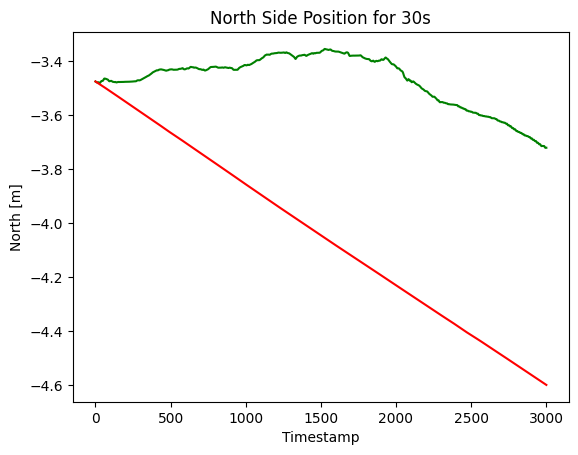

In [ ]:
# 초기값 설정
initial_North = data_TEST2['North'][61040]

# 실제 latitude 추정치 계산
North_predicted_TEST2 = [initial_North]
for change in predicted_North_TEST2:
    new_North_TEST2 = North_predicted_TEST2[-1] + change
    North_predicted_TEST2.append(new_North_TEST2)

# 실제 latitude 추정치 계산
North_actual_TEST2 = [initial_North]
for change in actual_North_TEST2:
    new_North_TEST2 = North_actual_TEST2[-1] + change
    North_actual_TEST2.append(new_North_TEST2)

# 시각화
plt.plot(North_actual_TEST2, label='Actual', c='g')
plt.plot(North_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

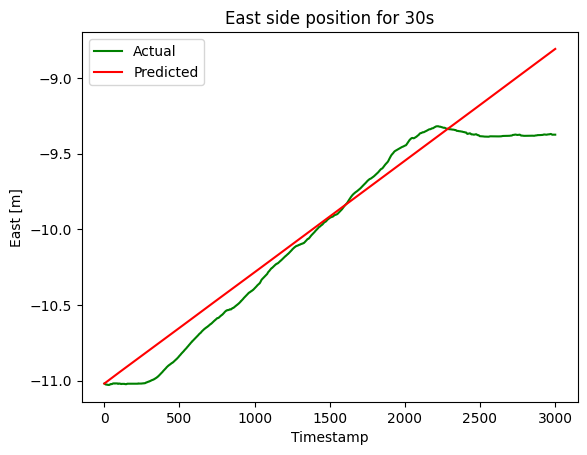

In [ ]:
# 초기값 설정
initial_East = data_TEST2['East'][61040]

# 실제 latitude 추정치 계산
East_predicted_TEST2 = [initial_East]
for change in predicted_East_TEST2:
    new_East_TEST2 = East_predicted_TEST2[-1] + change
    East_predicted_TEST2.append(new_East_TEST2)

# 실제 latitude 추정치 계산
East_actual_TEST2 = [initial_East]
for change in actual_East_TEST2:
    new_East_TEST2 = East_actual_TEST2[-1] + change
    East_actual_TEST2.append(new_East_TEST2)

# 시각화
plt.plot(East_actual_TEST2, label='Actual', c='g')
plt.plot(East_predicted_TEST2, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

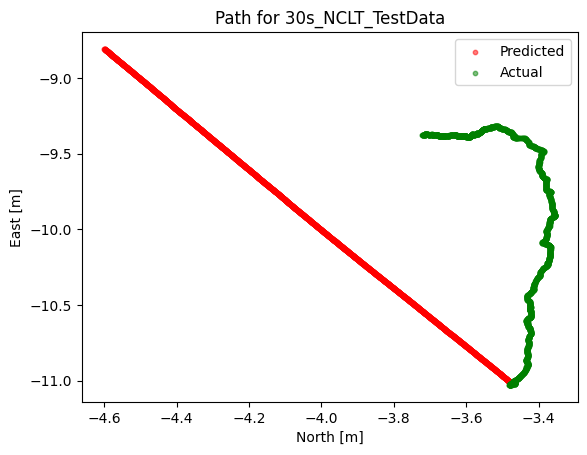

In [ ]:
plt.scatter(x=North_predicted_TEST2, y=East_predicted_TEST2, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST2, y=East_actual_TEST2, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

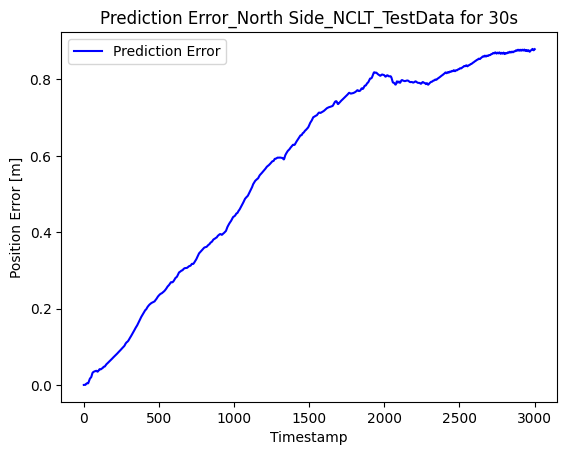

SE: 0.879 m
RMSE: 0.635 m


In [ ]:
East_actual_TEST2 = np.array(East_actual_TEST2)
North_actual_TEST2 = np.array(North_actual_TEST2)
East_predicted_TEST2 = np.array(East_predicted_TEST2)
North_predicted_TEST2 = np.array(North_predicted_TEST2)

SE_TEST2 = np.sqrt((North_actual_TEST2 - North_predicted_TEST2) ** 2)
RMSE_TEST2 = np.sqrt(np.mean((North_actual_TEST2 - North_predicted_TEST2) ** 2))

time_steps_TEST2 = np.arange(len(SE_TEST2))

plt.plot(time_steps_TEST2, SE_TEST2, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST2[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST2))

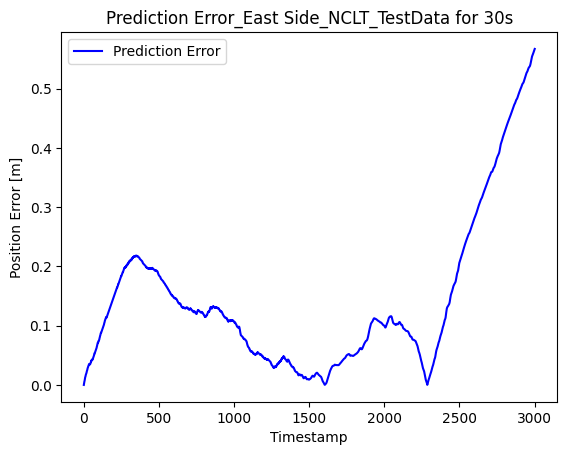

SE: 0.567 m
RMSE: 0.193 m


In [ ]:
SE_TEST2 = np.sqrt((East_actual_TEST2 - East_predicted_TEST2) ** 2)
RMSE_TEST2 = np.sqrt(np.mean((East_actual_TEST2 - East_predicted_TEST2) ** 2))

time_steps_TEST2 = np.arange(len(SE_TEST2))

plt.plot(time_steps_TEST2, SE_TEST2, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST2[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST2))

**TEST 3. 120122 NCLT robot data**

**예측 구간: 80020 ~83020 (30s)**

**곡선구간2**

In [ ]:
df_Course3 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])

TEST3_timestamps = 3040
window_size_TEST3 = 40
start_point_TEST3 = 80000
num_windows_TEST3 = TEST3_timestamps - window_size_TEST3 + 1

df_TEST3 = df_GPS_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3 = df_TEST3[['North', 'East']]

df_Accel_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST3 = df_Accel_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Accel_x_NED'] = df_TEST3['Accel_x_NED']
data_TEST3['Accel_y_NED'] = df_TEST3['Accel_y_NED']
data_TEST3['Accel_z_NED'] = df_TEST3['Accel_z_NED']

df_Euler_TEST3 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST3 = df_Euler_TEST3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Euler_x'] = df_TEST3['Euler_x']
data_TEST3['Euler_y'] = df_TEST3['Euler_y']
data_TEST3['Euler_z'] = df_TEST3['Euler_z']

df_TEST3 = df_Course3.iloc[start_point_TEST3:start_point_TEST3 + TEST3_timestamps]
data_TEST3['Gyro_x'] = df_TEST3['Gyro_x']
data_TEST3['Gyro_y'] = df_TEST3['Gyro_y']
data_TEST3['Gyro_z'] = df_TEST3['Gyro_z']
data_TEST3.head()

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
80000,-6.7435,-10.808,1.7642,0.49044,9.6509,73.022,8.7315,6.6792,-0.013335,-0.099604,-0.049679
80001,-6.7434,-10.808,1.7442,0.47723,9.6550,72.872,8.5995,6.6263,-0.015214,-0.111213,-0.045434
80002,-6.7431,-10.808,1.7209,0.46325,9.6603,72.725,8.4521,6.5599,-0.010204,-0.109142,-0.043727
80003,-6.7427,-10.809,1.6952,0.44837,9.6660,72.608,8.2922,6.4846,-0.005430,-0.107841,-0.021615
80004,-6.7422,-10.810,1.6691,0.43130,9.6718,72.516,8.1207,6.4154,0.001618,-0.107993,-0.016899


In [ ]:
delta_data_TEST3 = data_TEST3.diff(axis=0)
delta_North_TEST3 = delta_data_TEST3['North']
delta_East_TEST3 = delta_data_TEST3['East']

shifted_TEST3 = delta_data_TEST3[['North', 'East']].copy()
shifted_TEST3['Pred_N'] = shifted_TEST3['North'].shift(-window_size_TEST3)
shifted_TEST3['Pred_E'] = shifted_TEST3['East'].shift(-window_size_TEST3)

shifted_TEST3['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST3['Pred_E'].fillna(method='ffill', inplace = True)

In [ ]:
train_X_TEST3 =  data_TEST3[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST3 = train_X_TEST3.astype(np.float32)

train_y_TEST3 = shifted_TEST3[['Pred_N', 'Pred_E']].astype(np.float32)[:num_windows_TEST3]

x_data_TEST3 = train_X_TEST3[:num_windows_TEST3].values
x_data_TEST3 = np.array(x_data_TEST3)
x_data_TEST3 = x_data_TEST3.reshape(-1, 1, 9)
y_data_TEST3 = train_y_TEST3.values

print(x_data_TEST3.shape)
print(y_data_TEST3.shape)

(3001, 1, 9)
(3001, 2)


In [ ]:
x_data_TEST3 = x_data_TEST3.astype(np.float32)
y_data_TEST3 = y_data_TEST3.astype(np.float32)

sc_TEST3 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST3 = x_data_TEST3.reshape(-1, x_data_TEST3.shape[-1])
y_data_2d_TEST3 = y_data_TEST3.reshape(-1, y_data_TEST3.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST3 = sc_TEST3.fit_transform(x_data_2d_TEST3)
new_y_data_2d_TEST3 = sc_TEST3.fit_transform(y_data_2d_TEST3)

# 다시 3D로 변환
new_x_data_TEST3 = new_x_data_2d_TEST3.reshape(x_data_TEST3.shape)
new_y_data_TEST3 = new_y_data_2d_TEST3.reshape(y_data_TEST3.shape)

print(new_x_data_TEST3.shape)
print(new_y_data_TEST3.shape)

TEST3_array = []
for i in range(1, window_size + 1):
    x = np.roll(new_x_data_TEST3, shift=-i, axis=0)
    x[:i] = new_x_data_TEST3[-1]
    TEST3_array.append(x)

(3001, 1, 9)
(3001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST3 = model.predict(TEST3_array)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST3 = np.array(y_pred_TEST3)
new_y_data_array_TEST3 = np.array(new_y_data_TEST3)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST3 = y_preds_array_TEST3.reshape(-1, y_preds_array_TEST3.shape[-1])
new_y_data_flat_TEST3 = new_y_data_array_TEST3.reshape(-1, new_y_data_array_TEST3.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST3 = sc_TEST3.inverse_transform(y_preds_flat_TEST3)
rescaled_y_test_actual_N_E_TEST3 = sc_TEST3.inverse_transform(new_y_data_flat_TEST3)

# 위도와 경도값만 가져오기
predicted_North_TEST3 = rescaled_y_preds_N_E_TEST3[:, 0]
predicted_East_TEST3 = rescaled_y_preds_N_E_TEST3[:, 1]

actual_North_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 0]
actual_East_TEST3 = rescaled_y_test_actual_N_E_TEST3[:, 1]

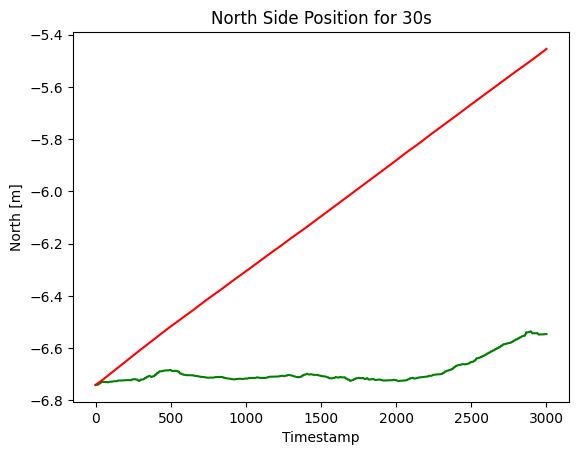

In [ ]:
# 초기값 설정
initial_North = data_TEST3['North'][80040]

# 실제 latitude 추정치 계산
North_predicted_TEST3 = [initial_North]
for change in predicted_North_TEST3:
    new_North_TEST3 = North_predicted_TEST3[-1] + change
    North_predicted_TEST3.append(new_North_TEST3)

# 실제 latitude 추정치 계산
North_actual_TEST3 = [initial_North]
for change in actual_North_TEST3:
    new_North_TEST3 = North_actual_TEST3[-1] + change
    North_actual_TEST3.append(new_North_TEST3)

# 시각화
plt.plot(North_actual_TEST3, label='Actual', c='g')
plt.plot(North_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

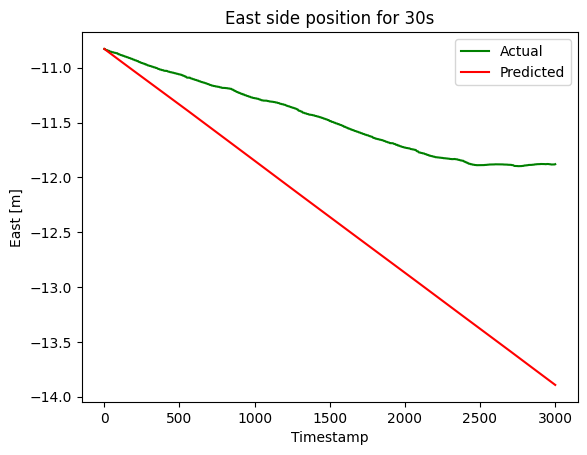

In [ ]:
# 초기값 설정
initial_East = data_TEST3['East'][80040]

# 실제 latitude 추정치 계산
East_predicted_TEST3 = [initial_East]
for change in predicted_East_TEST3:
    new_East_TEST3 = East_predicted_TEST3[-1] + change
    East_predicted_TEST3.append(new_East_TEST3)

# 실제 latitude 추정치 계산
East_actual_TEST3 = [initial_East]
for change in actual_East_TEST3:
    new_East_TEST3 = East_actual_TEST3[-1] + change
    East_actual_TEST3.append(new_East_TEST3)

# 시각화
plt.plot(East_actual_TEST3, label='Actual', c='g')
plt.plot(East_predicted_TEST3, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

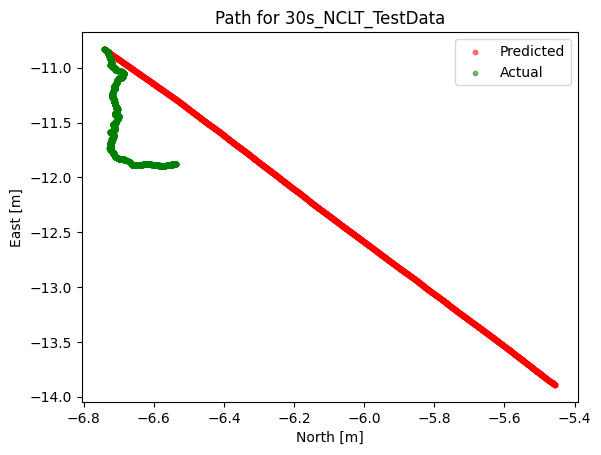

In [ ]:
plt.scatter(x=North_predicted_TEST3, y=East_predicted_TEST3, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST3, y=East_actual_TEST3, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

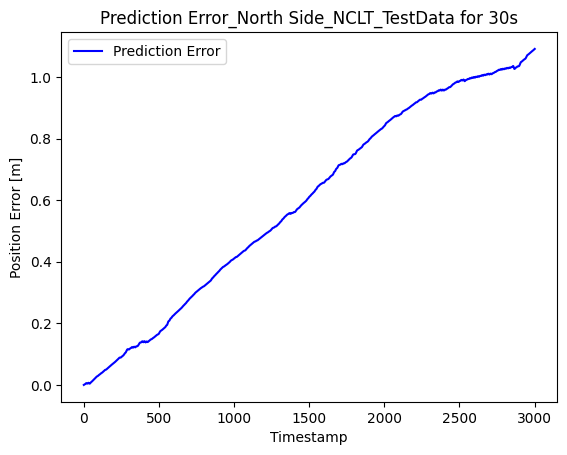

SE: 1.091 m
RMSE: 0.683 m


In [ ]:
East_actual_TEST3 = np.array(East_actual_TEST3)
North_actual_TEST3 = np.array(North_actual_TEST3)
East_predicted_TEST3 = np.array(East_predicted_TEST3)
North_predicted_TEST3 = np.array(North_predicted_TEST3)

SE_TEST3 = np.sqrt((North_actual_TEST3 - North_predicted_TEST3) ** 2)
RMSE_TEST3 = np.sqrt(np.mean((North_actual_TEST3 - North_predicted_TEST3) ** 2))

time_steps_TEST3 = np.arange(len(SE_TEST3))

plt.plot(time_steps_TEST3, SE_TEST3, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST3[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST3))

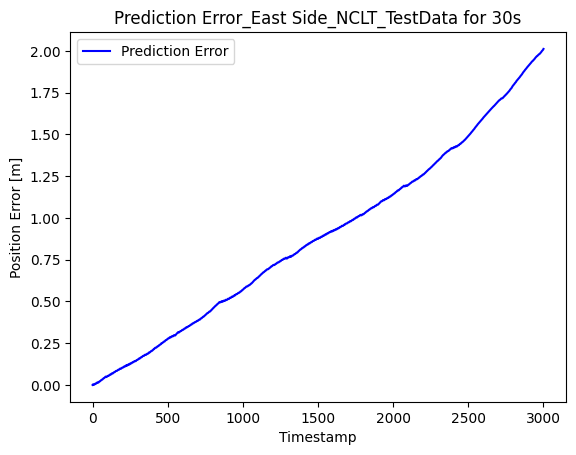

SE: 2.012 m
RMSE: 1.047 m


In [ ]:
SE_TEST3 = np.sqrt((East_actual_TEST3 - East_predicted_TEST3) ** 2)
RMSE_TEST3 = np.sqrt(np.mean((East_actual_TEST3 - East_predicted_TEST3) ** 2))

time_steps_TEST3 = np.arange(len(SE_TEST3))

plt.plot(time_steps_TEST3, SE_TEST3, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST3[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST3))

**TEST 4. 120122 NCLT robot data**

**예측 구간: 90020 ~93020 (30s)**

**직선구간2 (좌우)**

In [ ]:
df_Course4 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST4 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])

TEST4_timestamps = 3040
window_size_TEST4 = 40
start_point_TEST4 = 90000
num_windows_TEST4 = TEST4_timestamps - window_size_TEST4 + 1

df_TEST4 = df_GPS_TEST4.iloc[start_point_TEST4:start_point_TEST4 + TEST4_timestamps]
data_TEST4 = df_TEST4[['North', 'East']]

df_Accel_TEST4 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST4 = df_Accel_TEST4.iloc[start_point_TEST4:start_point_TEST4 + TEST4_timestamps]
data_TEST4['Accel_x_NED'] = df_TEST4['Accel_x_NED']
data_TEST4['Accel_y_NED'] = df_TEST4['Accel_y_NED']
data_TEST4['Accel_z_NED'] = df_TEST4['Accel_z_NED']

df_Euler_TEST4 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST4 = df_Euler_TEST4.iloc[start_point_TEST4:start_point_TEST4 + TEST4_timestamps]
data_TEST4['Euler_x'] = df_TEST4['Euler_x']
data_TEST4['Euler_y'] = df_TEST4['Euler_y']
data_TEST4['Euler_z'] = df_TEST4['Euler_z']

df_TEST4 = df_Course4.iloc[start_point_TEST4:start_point_TEST4 + TEST4_timestamps]
data_TEST4['Gyro_x'] = df_TEST4['Gyro_x']
data_TEST4['Gyro_y'] = df_TEST4['Gyro_y']
data_TEST4['Gyro_z'] = df_TEST4['Gyro_z']
data_TEST4.head()

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
90000,-6.0817,-12.995,0.41381,0.35434,9.7964,178.83,3.4599,0.66197,-0.002869,-0.011362,0.007481
90001,-6.0808,-12.995,0.41376,0.35810,9.7960,178.82,3.4776,0.64891,-0.000859,-0.008430,0.005539
90002,-6.0799,-12.996,0.41398,0.36253,9.7957,178.82,3.4994,0.63484,-0.000898,-0.012996,-0.002553
90003,-6.0789,-12.997,0.41484,0.36696,9.7954,178.82,3.5234,0.62378,-0.005710,-0.007685,-0.002557
90004,-6.0780,-12.997,0.41619,0.37162,9.7952,178.82,3.5501,0.61427,-0.000731,-0.009387,0.002488


In [ ]:
delta_data_TEST4 = data_TEST4.diff(axis=0)
delta_North_TEST4 = delta_data_TEST4['North']
delta_East_TEST4 = delta_data_TEST4['East']

shifted_TEST4 = delta_data_TEST4[['North', 'East']].copy()
shifted_TEST4['Pred_N'] = shifted_TEST4['North'].shift(-window_size_TEST4)
shifted_TEST4['Pred_E'] = shifted_TEST4['East'].shift(-window_size_TEST4)

shifted_TEST4['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST4['Pred_E'].fillna(method='ffill', inplace = True)

In [ ]:
train_X_TEST4 =  data_TEST4[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST4 = train_X_TEST4.astype(np.float32)

train_y_TEST4 = shifted_TEST4[['Pred_N', 'Pred_E']].astype(np.float32)[:num_windows_TEST4]

x_data_TEST4 = train_X_TEST4[:num_windows_TEST4].values
x_data_TEST4 = np.array(x_data_TEST4)
x_data_TEST4 = x_data_TEST4.reshape(-1, 1, 9)
y_data_TEST4 = train_y_TEST4.values

print(x_data_TEST4.shape)
print(y_data_TEST4.shape)

(3001, 1, 9)
(3001, 2)


In [ ]:
x_data_TEST4 = x_data_TEST4.astype(np.float32)
y_data_TEST4 = y_data_TEST4.astype(np.float32)

sc_TEST4 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST4 = x_data_TEST4.reshape(-1, x_data_TEST4.shape[-1])
y_data_2d_TEST4 = y_data_TEST4.reshape(-1, y_data_TEST4.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST4 = sc_TEST4.fit_transform(x_data_2d_TEST4)
new_y_data_2d_TEST4 = sc_TEST4.fit_transform(y_data_2d_TEST4)

# 다시 3D로 변환
new_x_data_TEST4 = new_x_data_2d_TEST4.reshape(x_data_TEST4.shape)
new_y_data_TEST4 = new_y_data_2d_TEST4.reshape(y_data_TEST4.shape)

print(new_x_data_TEST4.shape)
print(new_y_data_TEST4.shape)

TEST4_array = []
for i in range(1, window_size + 1):
    x = np.roll(new_x_data_TEST4, shift=-i, axis=0)
    x[:i] = new_x_data_TEST4[-1]
    TEST4_array.append(x)
print(np.array(TEST4_array).shape)

(3001, 1, 9)
(3001, 2)
(40, 3001, 1, 9)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST4 = model.predict(TEST4_array)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST4 = np.array(y_pred_TEST4)
new_y_data_array_TEST4 = np.array(new_y_data_TEST4)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST4 = y_preds_array_TEST4.reshape(-1, y_preds_array_TEST4.shape[-1])
new_y_data_flat_TEST4 = new_y_data_array_TEST4.reshape(-1, new_y_data_array_TEST4.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST4 = sc_TEST4.inverse_transform(y_preds_flat_TEST4)
rescaled_y_test_actual_N_E_TEST4 = sc_TEST4.inverse_transform(new_y_data_flat_TEST4)

# 위도와 경도값만 가져오기
predicted_North_TEST4 = rescaled_y_preds_N_E_TEST4[:, 0]
predicted_East_TEST4 = rescaled_y_preds_N_E_TEST4[:, 1]

actual_North_TEST4 = rescaled_y_test_actual_N_E_TEST4[:, 0]
actual_East_TEST4 = rescaled_y_test_actual_N_E_TEST4[:, 1]

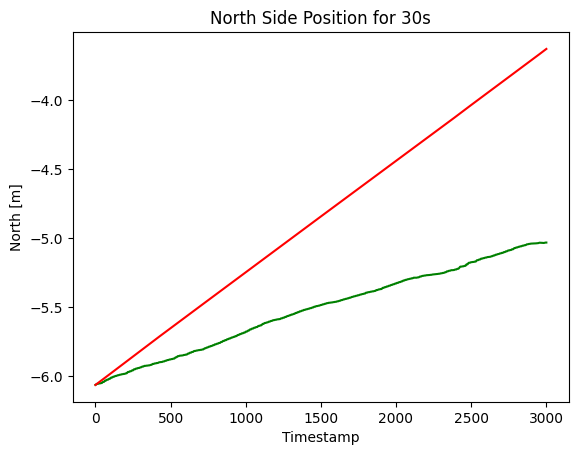

In [ ]:
# 초기값 설정
initial_North = data_TEST4['North'][90040]

# 실제 latitude 추정치 계산
North_predicted_TEST4 = [initial_North]
for change in predicted_North_TEST4:
    new_North_TEST4 = North_predicted_TEST4[-1] + change
    North_predicted_TEST4.append(new_North_TEST4)

# 실제 latitude 추정치 계산
North_actual_TEST4 = [initial_North]
for change in actual_North_TEST4:
    new_North_TEST4 = North_actual_TEST4[-1] + change
    North_actual_TEST4.append(new_North_TEST4)

# 시각화
plt.plot(North_actual_TEST4, label='Actual', c='g')
plt.plot(North_predicted_TEST4, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

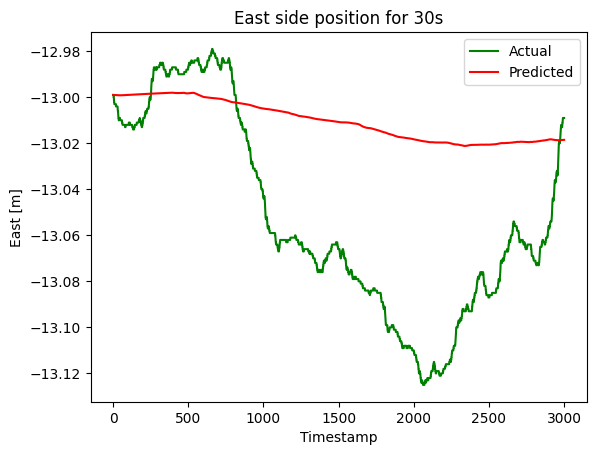

In [ ]:
# 초기값 설정
initial_East = data_TEST4['East'][90040]

# 실제 latitude 추정치 계산
East_predicted_TEST4 = [initial_East]
for change in predicted_East_TEST4:
    new_East_TEST4 = East_predicted_TEST4[-1] + change
    East_predicted_TEST4.append(new_East_TEST4)

# 실제 latitude 추정치 계산
East_actual_TEST4 = [initial_East]
for change in actual_East_TEST4:
    new_East_TEST4 = East_actual_TEST4[-1] + change
    East_actual_TEST4.append(new_East_TEST4)

# 시각화
plt.plot(East_actual_TEST4, label='Actual', c='g')
plt.plot(East_predicted_TEST4, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

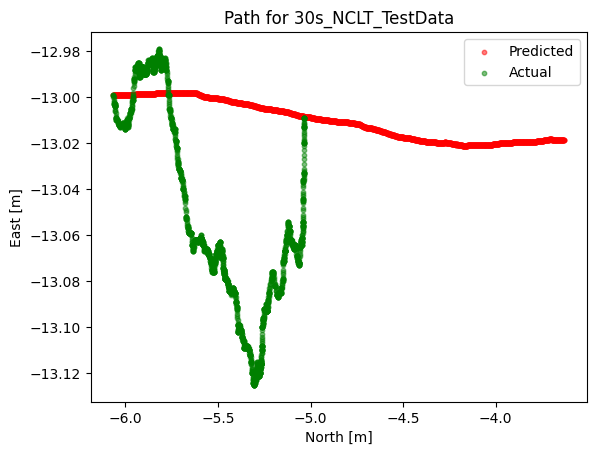

In [ ]:
plt.scatter(x=North_predicted_TEST4, y=East_predicted_TEST4, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST4, y=East_actual_TEST4, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

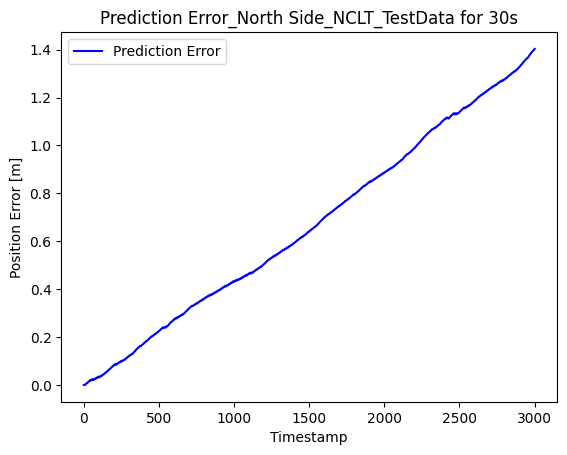

SE: 1.403 m
RMSE: 0.780 m


In [ ]:
East_actual_TEST4 = np.array(East_actual_TEST4)
North_actual_TEST4 = np.array(North_actual_TEST4)
East_predicted_TEST4 = np.array(East_predicted_TEST4)
North_predicted_TEST4 = np.array(North_predicted_TEST4)

SE_TEST4 = np.sqrt((North_actual_TEST4 - North_predicted_TEST4) ** 2)
RMSE_TEST4 = np.sqrt(np.mean((North_actual_TEST4 - North_predicted_TEST4) ** 2))

time_steps_TEST4 = np.arange(len(SE_TEST4))

plt.plot(time_steps_TEST4, SE_TEST4, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST4[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST4))

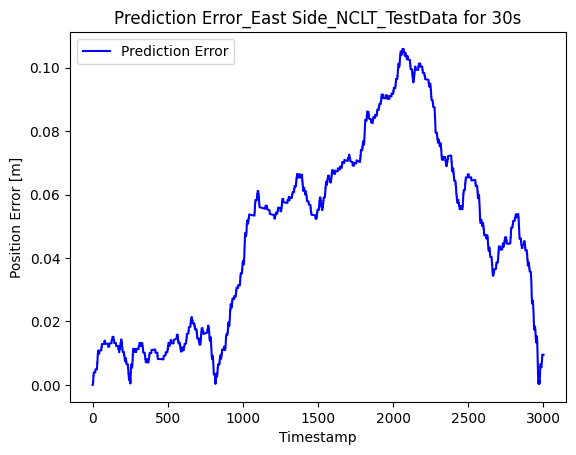

SE: 0.010 m
RMSE: 0.056 m


In [ ]:
SE_TEST4 = np.sqrt((East_actual_TEST4 - East_predicted_TEST4) ** 2)
RMSE_TEST4 = np.sqrt(np.mean((East_actual_TEST4 - East_predicted_TEST4) ** 2))

time_steps_TEST4 = np.arange(len(SE_TEST4))

plt.plot(time_steps_TEST4, SE_TEST4, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST4[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST4))

**TEST 5. 120122 NCLT robot data**

**예측 구간: 100020 ~103020 (30s)**

**직선구간3 (N&E 모두 증가)**

In [ ]:
df_Course5 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST5 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])

TEST5_timestamps = 3040
window_size_TEST5 = 40
start_point_TEST5 = 100500
num_windows_TEST5 = TEST5_timestamps - window_size_TEST5 + 1

df_TEST5 = df_GPS_TEST5.iloc[start_point_TEST5:start_point_TEST5 + TEST5_timestamps]
data_TEST5 = df_TEST5[['North', 'East']]

df_Accel_TEST5 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST5 = df_Accel_TEST5.iloc[start_point_TEST5:start_point_TEST5 + TEST5_timestamps]
data_TEST5['Accel_x_NED'] = df_TEST5['Accel_x_NED']
data_TEST5['Accel_y_NED'] = df_TEST5['Accel_y_NED']
data_TEST5['Accel_z_NED'] = df_TEST5['Accel_z_NED']

df_Euler_TEST5 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST5 = df_Euler_TEST5.iloc[start_point_TEST5:start_point_TEST5 + TEST5_timestamps]
data_TEST5['Euler_x'] = df_TEST5['Euler_x']
data_TEST5['Euler_y'] = df_TEST5['Euler_y']
data_TEST5['Euler_z'] = df_TEST5['Euler_z']

df_TEST5 = df_Course5.iloc[start_point_TEST5:start_point_TEST5 + TEST5_timestamps]
data_TEST5['Gyro_x'] = df_TEST5['Gyro_x']
data_TEST5['Gyro_y'] = df_TEST5['Gyro_y']
data_TEST5['Gyro_z'] = df_TEST5['Gyro_z']
data_TEST5.head()

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
100500,-3.8487,-14.560,-0.86234,0.028358,9.7839,136.28,-2.4425,-4.2750,-0.026605,-0.017455,-0.131958
100501,-3.8482,-14.560,-0.89129,0.059598,9.7819,136.23,-2.3933,-4.5190,0.006880,-0.015868,-0.148584
100502,-3.8475,-14.559,-0.91886,0.079068,9.7768,136.10,-2.3959,-4.7177,0.049845,-0.017830,-0.163415
100503,-3.8467,-14.559,-0.95516,0.090152,9.7706,135.91,-2.4682,-4.9298,0.086580,-0.011397,-0.173146
100504,-3.8459,-14.558,-0.98511,0.084474,9.7661,135.70,-2.5980,-5.0541,0.108856,-0.013439,-0.148482


In [ ]:
delta_data_TEST5 = data_TEST5.diff(axis=0)
delta_North_TEST5 = delta_data_TEST5['North']
delta_East_TEST5 = delta_data_TEST5['East']

shifted_TEST5 = delta_data_TEST5[['North', 'East']].copy()
shifted_TEST5['Pred_N'] = shifted_TEST5['North'].shift(-window_size_TEST5)
shifted_TEST5['Pred_E'] = shifted_TEST5['East'].shift(-window_size_TEST5)

shifted_TEST5['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST5['Pred_E'].fillna(method='ffill', inplace = True)

In [ ]:
train_X_TEST5 =  data_TEST5[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST5 = train_X_TEST5.astype(np.float32)

train_y_TEST5 = shifted_TEST5[['Pred_N', 'Pred_E']].astype(np.float32)[:num_windows_TEST5]

x_data_TEST5 = train_X_TEST5[:num_windows_TEST5].values
x_data_TEST5 = np.array(x_data_TEST5)
x_data_TEST5 = x_data_TEST5.reshape(-1, 1, 9)
y_data_TEST5 = train_y_TEST5.values

print(x_data_TEST5.shape)
print(y_data_TEST5.shape)

(3001, 1, 9)
(3001, 2)


In [ ]:
x_data_TEST5 = x_data_TEST5.astype(np.float32)
y_data_TEST5 = y_data_TEST5.astype(np.float32)

sc_TEST5 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST5 = x_data_TEST5.reshape(-1, x_data_TEST5.shape[-1])
y_data_2d_TEST5 = y_data_TEST5.reshape(-1, y_data_TEST5.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST5 = sc_TEST5.fit_transform(x_data_2d_TEST5)
new_y_data_2d_TEST5 = sc_TEST5.fit_transform(y_data_2d_TEST5)

# 다시 3D로 변환
new_x_data_TEST5 = new_x_data_2d_TEST5.reshape(x_data_TEST5.shape)
new_y_data_TEST5 = new_y_data_2d_TEST5.reshape(y_data_TEST5.shape)

print(new_x_data_TEST5.shape)
print(new_y_data_TEST5.shape)

TEST5_array = []
for i in range(1, window_size + 1):
    x = np.roll(new_x_data_TEST5, shift=-i, axis=0)
    x[:i] = new_x_data_TEST5[-1]
    TEST5_array.append(x)

(3001, 1, 9)
(3001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST5 = model.predict(TEST5_array)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST5 = np.array(y_pred_TEST5)
new_y_data_array_TEST5 = np.array(new_y_data_TEST5)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST5 = y_preds_array_TEST5.reshape(-1, y_preds_array_TEST5.shape[-1])
new_y_data_flat_TEST5 = new_y_data_array_TEST5.reshape(-1, new_y_data_array_TEST5.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST5 = sc_TEST5.inverse_transform(y_preds_flat_TEST5)
rescaled_y_test_actual_N_E_TEST5 = sc_TEST5.inverse_transform(new_y_data_flat_TEST5)

# 위도와 경도값만 가져오기
predicted_North_TEST5 = rescaled_y_preds_N_E_TEST5[:, 0]
predicted_East_TEST5 = rescaled_y_preds_N_E_TEST5[:, 1]

actual_North_TEST5 = rescaled_y_test_actual_N_E_TEST5[:, 0]
actual_East_TEST5 = rescaled_y_test_actual_N_E_TEST5[:, 1]

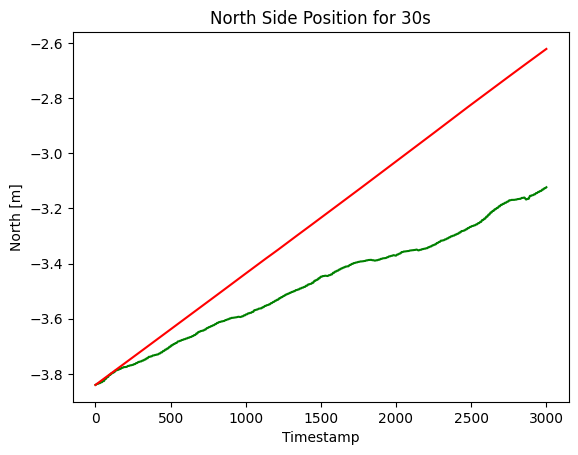

In [ ]:
# 초기값 설정
initial_North = data_TEST5['North'][100540]

# 실제 latitude 추정치 계산
North_predicted_TEST5 = [initial_North]
for change in predicted_North_TEST5:
    new_North_TEST5 = North_predicted_TEST5[-1] + change
    North_predicted_TEST5.append(new_North_TEST5)

# 실제 latitude 추정치 계산
North_actual_TEST5 = [initial_North]
for change in actual_North_TEST5:
    new_North_TEST5 = North_actual_TEST5[-1] + change
    North_actual_TEST5.append(new_North_TEST5)

# 시각화
plt.plot(North_actual_TEST5, label='Actual', c='g')
plt.plot(North_predicted_TEST5, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

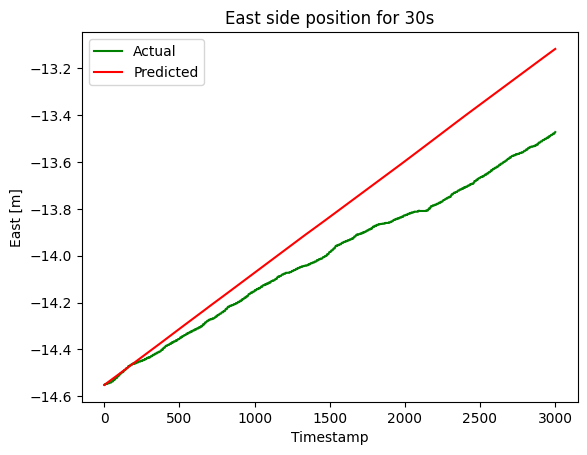

In [ ]:
# 초기값 설정
initial_East = data_TEST5['East'][100540]

# 실제 latitude 추정치 계산
East_predicted_TEST5 = [initial_East]
for change in predicted_East_TEST5:
    new_East_TEST5 = East_predicted_TEST5[-1] + change
    East_predicted_TEST5.append(new_East_TEST5)

# 실제 latitude 추정치 계산
East_actual_TEST5 = [initial_East]
for change in actual_East_TEST5:
    new_East_TEST5 = East_actual_TEST5[-1] + change
    East_actual_TEST5.append(new_East_TEST5)

# 시각화
plt.plot(East_actual_TEST5, label='Actual', c='g')
plt.plot(East_predicted_TEST5, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

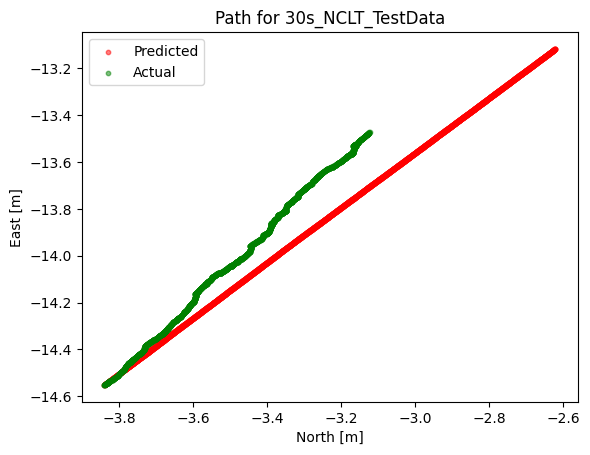

In [ ]:
plt.scatter(x=North_predicted_TEST5, y=East_predicted_TEST5, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST5, y=East_actual_TEST5, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

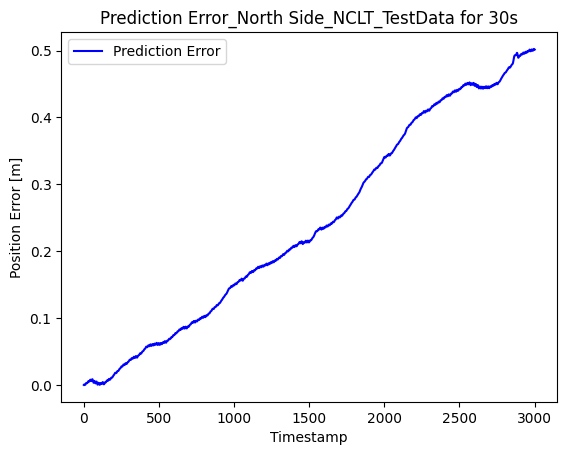

SE: 0.501 m
RMSE: 0.288 m


In [ ]:
East_actual_TEST5 = np.array(East_actual_TEST5)
North_actual_TEST5 = np.array(North_actual_TEST5)
East_predicted_TEST5 = np.array(East_predicted_TEST5)
North_predicted_TEST5 = np.array(North_predicted_TEST5)

SE_TEST5 = np.sqrt((North_actual_TEST5 - North_predicted_TEST5) ** 2)
RMSE_TEST5 = np.sqrt(np.mean((North_actual_TEST5 - North_predicted_TEST5) ** 2))

time_steps_TEST5 = np.arange(len(SE_TEST5))

plt.plot(time_steps_TEST5, SE_TEST5, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST5[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST5))

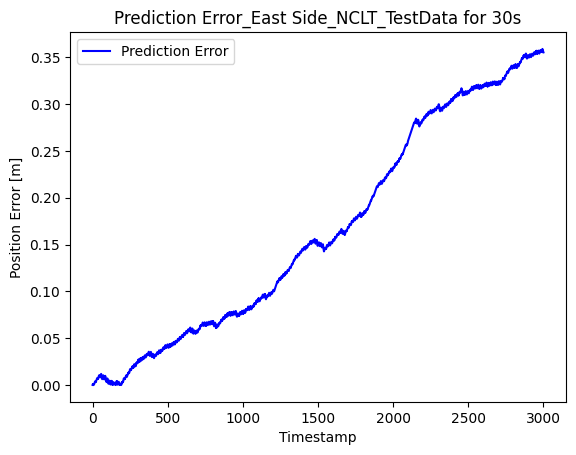

SE: 0.355 m
RMSE: 0.202 m


In [ ]:
SE_TEST5 = np.sqrt((East_actual_TEST5 - East_predicted_TEST5) ** 2)
RMSE_TEST5 = np.sqrt(np.mean((East_actual_TEST5 - East_predicted_TEST5) ** 2))

time_steps_TEST5 = np.arange(len(SE_TEST5))

plt.plot(time_steps_TEST5, SE_TEST5, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST5[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST5))

**TEST 6. 120122 NCLT robot data**

**예측 구간: 115020 ~115020 (30s)**

**곡선구간3**

In [ ]:
df_Course6 = pd.read_csv('/content/sample_data/120122_robot/120122_ms25.csv', usecols=[7, 8, 9], header=None, names=['Gyro_x', 'Gyro_y', 'Gyro_z'])

df_GPS_TEST6 = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East'], usecols=[0,1])

TEST6_timestamps = 3040
window_size_TEST6 = 40
start_point_TEST6 = 115000
num_windows_TEST6 = TEST6_timestamps - window_size_TEST6 + 1

df_TEST6 = df_GPS_TEST6.iloc[start_point_TEST6:start_point_TEST6 + TEST6_timestamps]
data_TEST6 = df_TEST6[['North', 'East']]

df_Accel_TEST6 = pd.read_csv('/content/sample_data/120122_robot/120122_nedaccel.csv', header = None
                     , names = ['Accel_x_NED', 'Accel_y_NED', 'Accel_z_NED'])
df_TEST6 = df_Accel_TEST6.iloc[start_point_TEST6:start_point_TEST6 + TEST6_timestamps]
data_TEST6['Accel_x_NED'] = df_TEST6['Accel_x_NED']
data_TEST6['Accel_y_NED'] = df_TEST6['Accel_y_NED']
data_TEST6['Accel_z_NED'] = df_TEST6['Accel_z_NED']

df_Euler_TEST6 = pd.read_csv('/content/sample_data/120122_robot/120122_nedeuler.csv', header = None
                     , names = ['Euler_x', 'Euler_y', 'Euler_z'])
df_TEST6 = df_Euler_TEST6.iloc[start_point_TEST6:start_point_TEST6 + TEST6_timestamps]
data_TEST6['Euler_x'] = df_TEST6['Euler_x']
data_TEST6['Euler_y'] = df_TEST6['Euler_y']
data_TEST6['Euler_z'] = df_TEST6['Euler_z']

df_TEST6 = df_Course6.iloc[start_point_TEST6:start_point_TEST6 + TEST6_timestamps]
data_TEST6['Gyro_x'] = df_TEST6['Gyro_x']
data_TEST6['Gyro_y'] = df_TEST6['Gyro_y']
data_TEST6['Gyro_z'] = df_TEST6['Gyro_z']
data_TEST6.head()

,North,East,Accel_x_NED,Accel_y_NED,Accel_z_NED,Euler_x,Euler_y,Euler_z,Gyro_x,Gyro_y,Gyro_z
115000,-2.9017,-16.641,-0.059319,-0.045149,9.8071,19.906,-0.049798,-0.216750,-0.026557,-0.013095,0.035963
115001,-2.9019,-16.641,-0.045467,-0.063189,9.8092,19.994,-0.087883,-0.089474,-0.030328,-0.007774,0.031926
115002,-2.9020,-16.641,-0.035638,-0.072734,9.8121,20.083,-0.099403,-0.010327,-0.038817,-0.013794,0.025740
115003,-2.9019,-16.641,-0.022000,-0.085898,9.8145,20.163,-0.115080,0.099173,-0.036050,-0.009348,0.024444
115004,-2.9018,-16.641,-0.004234,-0.107090,9.8150,20.309,-0.154750,0.255610,-0.033388,-0.011425,0.005682


In [ ]:
delta_data_TEST6 = data_TEST6.diff(axis=0)
delta_North_TEST6 = delta_data_TEST6['North']
delta_East_TEST6 = delta_data_TEST6['East']

shifted_TEST6 = delta_data_TEST6[['North', 'East']].copy()
shifted_TEST6['Pred_N'] = shifted_TEST6['North'].shift(-window_size_TEST6)
shifted_TEST6['Pred_E'] = shifted_TEST6['East'].shift(-window_size_TEST6)

shifted_TEST6['Pred_N'].fillna(method='ffill', inplace = True)
shifted_TEST6['Pred_E'].fillna(method='ffill', inplace = True)

In [ ]:
train_X_TEST6 =  data_TEST6[['Accel_x_NED', 'Accel_y_NED',  'Accel_z_NED', 'Euler_x', 'Euler_y',  'Euler_z', 'Gyro_x', 'Gyro_y', 'Gyro_z']]
train_X_TEST6 = train_X_TEST6.astype(np.float32)

train_y_TEST6 = shifted_TEST6[['Pred_N', 'Pred_E']].astype(np.float32)[:num_windows_TEST6]

x_data_TEST6 = train_X_TEST6[:num_windows_TEST6].values
x_data_TEST6 = np.array(x_data_TEST6)
x_data_TEST6 = x_data_TEST6.reshape(-1, 1, 9)
y_data_TEST6 = train_y_TEST6.values

print(x_data_TEST6.shape)
print(y_data_TEST6.shape)

(3001, 1, 9)
(3001, 2)


In [ ]:
x_data_TEST6 = x_data_TEST6.astype(np.float32)
y_data_TEST6 = y_data_TEST6.astype(np.float32)

sc_TEST6 = MinMaxScaler(feature_range=(-1,1))

# 3D 배열을 2D로 변환
x_data_2d_TEST6 = x_data_TEST6.reshape(-1, x_data_TEST6.shape[-1])
y_data_2d_TEST6 = y_data_TEST6.reshape(-1, y_data_TEST6.shape[-1])

# 스케일링 적용
new_x_data_2d_TEST6 = sc_TEST6.fit_transform(x_data_2d_TEST6)
new_y_data_2d_TEST6 = sc_TEST6.fit_transform(y_data_2d_TEST6)

# 다시 3D로 변환
new_x_data_TEST6 = new_x_data_2d_TEST6.reshape(x_data_TEST6.shape)
new_y_data_TEST6 = new_y_data_2d_TEST6.reshape(y_data_TEST6.shape)

print(new_x_data_TEST6.shape)
print(new_y_data_TEST6.shape)

TEST6_array = []
for i in range(1, window_size + 1):
    x = np.roll(new_x_data_TEST6, shift=-i, axis=0)
    x[:i] = new_x_data_TEST6[-1]
    TEST6_array.append(x)

(3001, 1, 9)
(3001, 2)


In [ ]:
if __name__ == "__main__":

    y_pred_TEST6 = model.predict(TEST6_array)

In [ ]:
import numpy as np

# 리스트를 NumPy 배열로 변환
y_preds_array_TEST6 = np.array(y_pred_TEST6)
new_y_data_array_TEST6 = np.array(new_y_data_TEST6)

# 3차원 배열을 2차원 배열로 변환
y_preds_flat_TEST6 = y_preds_array_TEST6.reshape(-1, y_preds_array_TEST6.shape[-1])
new_y_data_flat_TEST6 = new_y_data_array_TEST6.reshape(-1, new_y_data_array_TEST6.shape[-1])

# 예측값의 스케일을 되돌리기 위한 역변환
rescaled_y_preds_N_E_TEST6 = sc_TEST6.inverse_transform(y_preds_flat_TEST6)
rescaled_y_test_actual_N_E_TEST6 = sc_TEST6.inverse_transform(new_y_data_flat_TEST6)

# 위도와 경도값만 가져오기
predicted_North_TEST6 = rescaled_y_preds_N_E_TEST6[:, 0]
predicted_East_TEST6 = rescaled_y_preds_N_E_TEST6[:, 1]

actual_North_TEST6 = rescaled_y_test_actual_N_E_TEST6[:, 0]
actual_East_TEST6 = rescaled_y_test_actual_N_E_TEST6[:, 1]

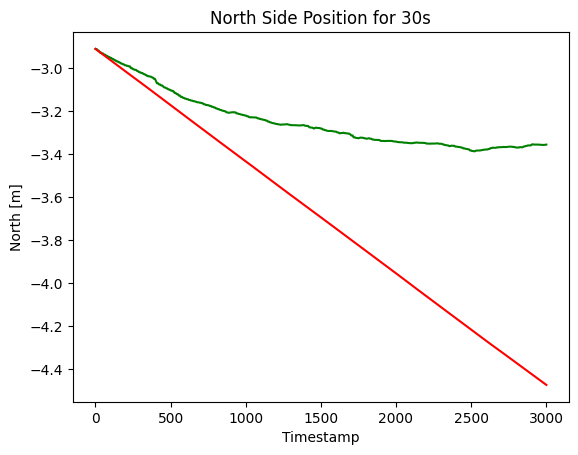

In [ ]:
# 초기값 설정
initial_North = data_TEST6['North'][115040]

# 실제 latitude 추정치 계산
North_predicted_TEST6 = [initial_North]
for change in predicted_North_TEST6:
    new_North_TEST6 = North_predicted_TEST6[-1] + change
    North_predicted_TEST6.append(new_North_TEST6)

# 실제 latitude 추정치 계산
North_actual_TEST6 = [initial_North]
for change in actual_North_TEST6:
    new_North_TEST6 = North_actual_TEST6[-1] + change
    North_actual_TEST6.append(new_North_TEST6)

# 시각화
plt.plot(North_actual_TEST6, label='Actual', c='g')
plt.plot(North_predicted_TEST6, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('North [m]')
plt.title('North Side Position for 30s')
plt.show()

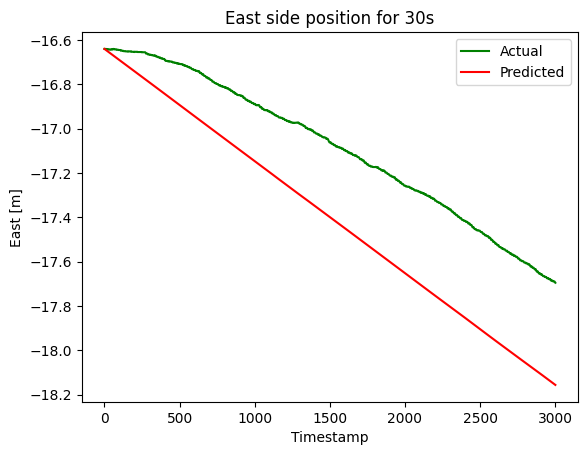

In [ ]:
# 초기값 설정
initial_East = data_TEST6['East'][115040]

# 실제 latitude 추정치 계산
East_predicted_TEST6 = [initial_East]
for change in predicted_East_TEST6:
    new_East_TEST6 = East_predicted_TEST6[-1] + change
    East_predicted_TEST6.append(new_East_TEST6)

# 실제 latitude 추정치 계산
East_actual_TEST6 = [initial_East]
for change in actual_East_TEST6:
    new_East_TEST6 = East_actual_TEST6[-1] + change
    East_actual_TEST6.append(new_East_TEST6)

# 시각화
plt.plot(East_actual_TEST6, label='Actual', c='g')
plt.plot(East_predicted_TEST6, label='Predicted', c='r')
plt.xlabel('Timestamp')
plt.ylabel('East [m]')
plt.title('East side position for 30s')
plt.legend()
plt.show()

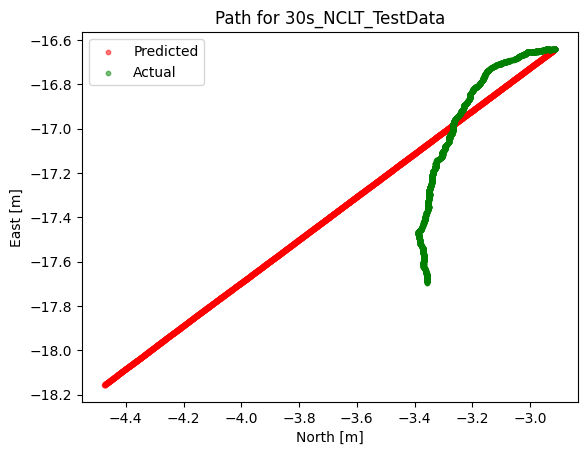

In [ ]:
plt.scatter(x=North_predicted_TEST6, y=East_predicted_TEST6, label='Predicted', c='r', s=10, alpha=0.5)
plt.scatter(x=North_actual_TEST6, y=East_actual_TEST6, label='Actual', c='g', s=10, alpha=0.5)
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.title('Path for 30s_NCLT_TestData')
plt.legend()
plt.show()

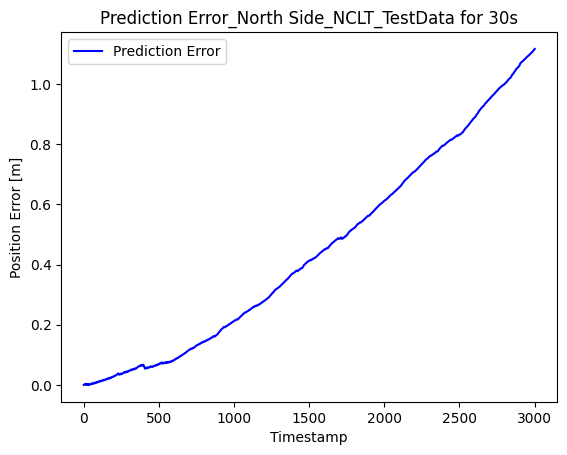

SE: 1.117 m
RMSE: 0.559 m


In [ ]:
East_actual_TEST6 = np.array(East_actual_TEST6)
North_actual_TEST6 = np.array(North_actual_TEST6)
East_predicted_TEST6 = np.array(East_predicted_TEST6)
North_predicted_TEST6 = np.array(North_predicted_TEST6)

SE_TEST6 = np.sqrt((North_actual_TEST6 - North_predicted_TEST6) ** 2)
RMSE_TEST6 = np.sqrt(np.mean((North_actual_TEST6 - North_predicted_TEST6) ** 2))

time_steps_TEST6 = np.arange(len(SE_TEST6))

plt.plot(time_steps_TEST6, SE_TEST6, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_North Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST6[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST6))

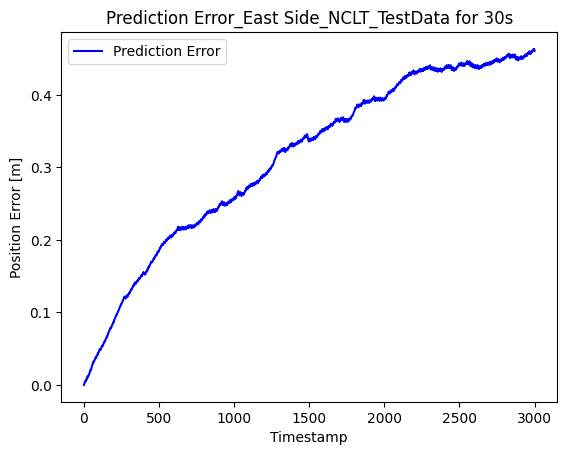

SE: 0.461 m
RMSE: 0.336 m


In [ ]:
SE_TEST6 = np.sqrt((East_actual_TEST6 - East_predicted_TEST6) ** 2)
RMSE_TEST6 = np.sqrt(np.mean((East_actual_TEST6 - East_predicted_TEST6) ** 2))

time_steps_TEST6 = np.arange(len(SE_TEST6))

plt.plot(time_steps_TEST6, SE_TEST6, label='Prediction Error', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Position Error [m]')
plt.title('Prediction Error_East Side_NCLT_TestData for 30s')
plt.legend()
plt.show()

print('SE: {:.3f} m'.format(SE_TEST6[-1]))
print('RMSE: {:.3f} m'.format(RMSE_TEST6))

In [ ]:
df_P_Course1=pd.DataFrame(North_predicted_TEST1, columns=['North'])
df_P_Course1['East']=East_predicted_TEST1
df_GPS_TEST3.iloc[53040:56042] = df_P_Course1.values

df_P_Course2=pd.DataFrame(North_predicted_TEST2, columns=['North'])
df_P_Course2['East']=East_predicted_TEST2
df_GPS_TEST3.iloc[61040:64042] = df_P_Course2.values

df_P_Course3=pd.DataFrame(North_predicted_TEST3, columns=['North'])
df_P_Course3['East']=East_predicted_TEST3
df_GPS_TEST3.iloc[80040:83042] = df_P_Course3.values

df_P_Course4=pd.DataFrame(North_predicted_TEST4, columns=['North'])
df_P_Course4['East']=East_predicted_TEST4
df_GPS_TEST3.iloc[90040:93042] = df_P_Course4.values

df_P_Course5=pd.DataFrame(North_predicted_TEST5, columns=['North'])
df_P_Course5['East']=East_predicted_TEST5
df_GPS_TEST3.iloc[100540:103542] = df_P_Course5.values

df_P_Course6=pd.DataFrame(North_predicted_TEST6, columns=['North'])
df_P_Course6['East']=East_predicted_TEST6
df_GPS_TEST3.iloc[115040:118042] = df_P_Course6.values

In [ ]:
Predict_120122_path = '/content/sample_data/120122_robot/120122_predicted_gps.csv'
df_GPS_TEST3.to_csv(Predict_120122_path, index=False)

**음영구간에서 예측모델로 예측한 값을 사용하여 나타낸 전체 경로**

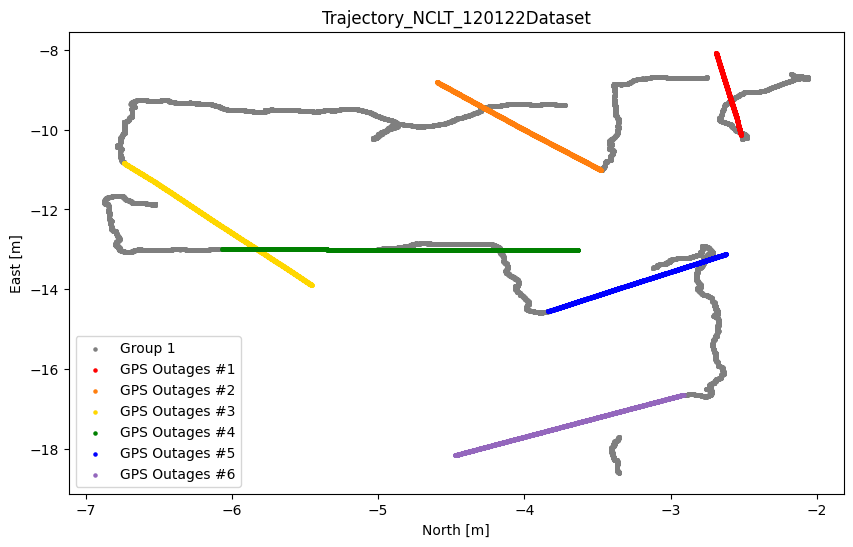

In [ ]:
df1 = df_GPS_TEST3.iloc[50000:53040]
df2 = df_GPS_TEST3.iloc[53040:56042]
df3 = df_GPS_TEST3.iloc[56042:61040]
df4 = df_GPS_TEST3.iloc[61040:64042]
df5 = df_GPS_TEST3.iloc[64042:80040]
df6 = df_GPS_TEST3.iloc[80040:83042]
df7 = df_GPS_TEST3.iloc[83042:90040]
df8 = df_GPS_TEST3.iloc[90040:93042]
df9 = df_GPS_TEST3.iloc[93042:100540]
df10 = df_GPS_TEST3.iloc[100540:103542]
df11 = df_GPS_TEST3.iloc[103542:115040]
df12 = df_GPS_TEST3.iloc[115040:118042]
df13 = df_GPS_TEST3.iloc[118042:120000]

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='tab:gray', label='Group 1', s=5)
plt.scatter(df3['North'], df3['East'], color='tab:gray', s=5)
plt.scatter(df5['North'], df5['East'], color='tab:gray', s=5)
plt.scatter(df7['North'], df7['East'], color='tab:gray', s=5)
plt.scatter(df9['North'], df9['East'], color='tab:gray', s=5)
plt.scatter(df11['North'], df11['East'], color='tab:gray', s=5)
plt.scatter(df13['North'], df13['East'], color='tab:gray', s=5)

plt.scatter(df2['North'], df2['East'], color='red', label='GPS Outages #1', s=5)
plt.scatter(df4['North'], df4['East'], color='tab:orange', label='GPS Outages #2', s=5)
plt.scatter(df6['North'], df6['East'], color='gold', label='GPS Outages #3', s=5)
plt.scatter(df8['North'], df8['East'], color='g', label='GPS Outages #4', s=5)
plt.scatter(df10['North'], df10['East'], color='b', label='GPS Outages #5', s=5)
plt.scatter(df12['North'], df12['East'], color='tab:purple', label='GPS Outages #6', s=5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()

**음영구간 가정을 포함한 전체 경로**

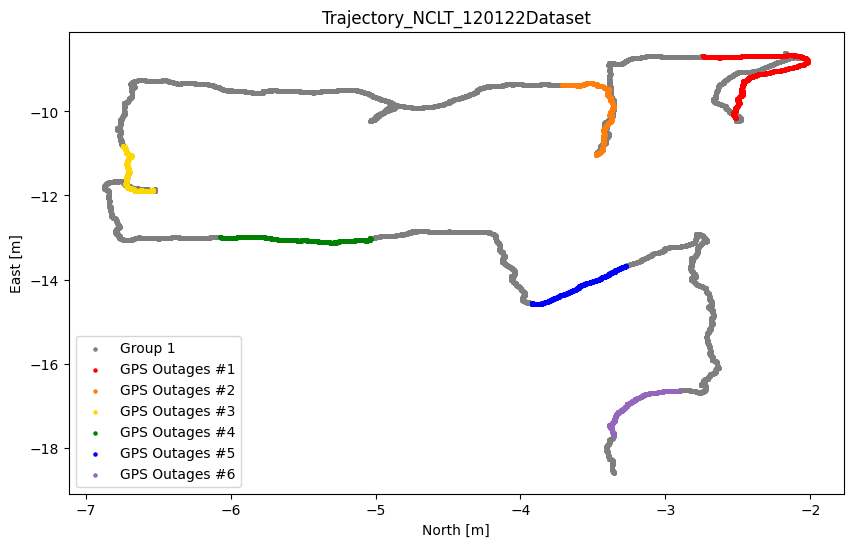

In [ ]:
df_GPS = pd.read_csv('/content/sample_data/120122_robot/120122_nedgps.csv', header = None, names = ['North', 'East', 'Down'])

df1 = df_GPS.iloc[50000:53020]
df2 = df_GPS.iloc[53020:56020]
df3 = df_GPS.iloc[56020:61020]
df4 = df_GPS.iloc[61020:64020]
df5 = df_GPS.iloc[64020:80020]
df6 = df_GPS.iloc[80020:83020]
df7 = df_GPS.iloc[83020:90020]
df8 = df_GPS.iloc[90020:93020]
df9 = df_GPS.iloc[93020:100020]
df10 = df_GPS.iloc[100020:103020]
df11 = df_GPS.iloc[103020:115020]
df12 = df_GPS.iloc[115020:118020]
df13 = df_GPS.iloc[118020:120000]

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='tab:gray', label='Group 1', s=5)
plt.scatter(df3['North'], df3['East'], color='tab:gray', s=5)
plt.scatter(df5['North'], df5['East'], color='tab:gray', s=5)
plt.scatter(df7['North'], df7['East'], color='tab:gray', s=5)
plt.scatter(df9['North'], df9['East'], color='tab:gray', s=5)
plt.scatter(df11['North'], df11['East'], color='tab:gray', s=5)
plt.scatter(df13['North'], df13['East'], color='tab:gray', s=5)

plt.scatter(df2['North'], df2['East'], color='red', label='GPS Outages #1', s=5)
plt.scatter(df4['North'], df4['East'], color='tab:orange', label='GPS Outages #2', s=5)
plt.scatter(df6['North'], df6['East'], color='gold', label='GPS Outages #3', s=5)
plt.scatter(df8['North'], df8['East'], color='g', label='GPS Outages #4', s=5)
plt.scatter(df10['North'], df10['East'], color='b', label='GPS Outages #5', s=5)
plt.scatter(df12['North'], df12['East'], color='tab:purple', label='GPS Outages #6', s=5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()


In [ ]:
pip install folium

**칼만필터 돌린 전체 경로**

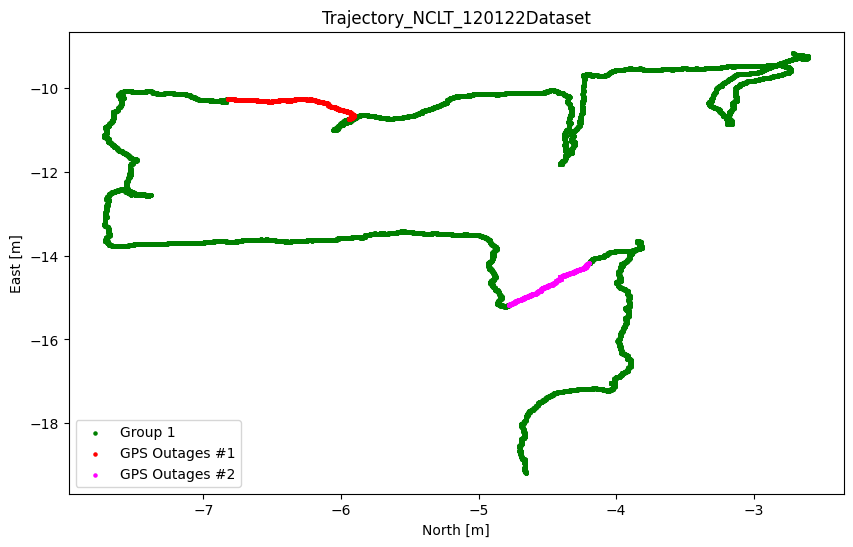

In [ ]:
df_GPS = pd.read_csv('/content/position.csv', header = None, names = ['North', 'East'])

df1 = df_GPS.iloc[50000:70020]
df2 = df_GPS.iloc[70020:73022]
df3 = df_GPS.iloc[73022:100520]
df4 = df_GPS.iloc[100520:103522]
df5 = df_GPS.iloc[103522:120000]

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='green', label='Group 1', s=5)
plt.scatter(df3['North'], df3['East'], color='green', s=5)
plt.scatter(df5['North'], df5['East'], color='green', s=5)

plt.scatter(df2['North'], df2['East'], color='red', label='GPS Outages #1', s=5)
plt.scatter(df4['North'], df4['East'], color='magenta', label='GPS Outages #2', s=5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()


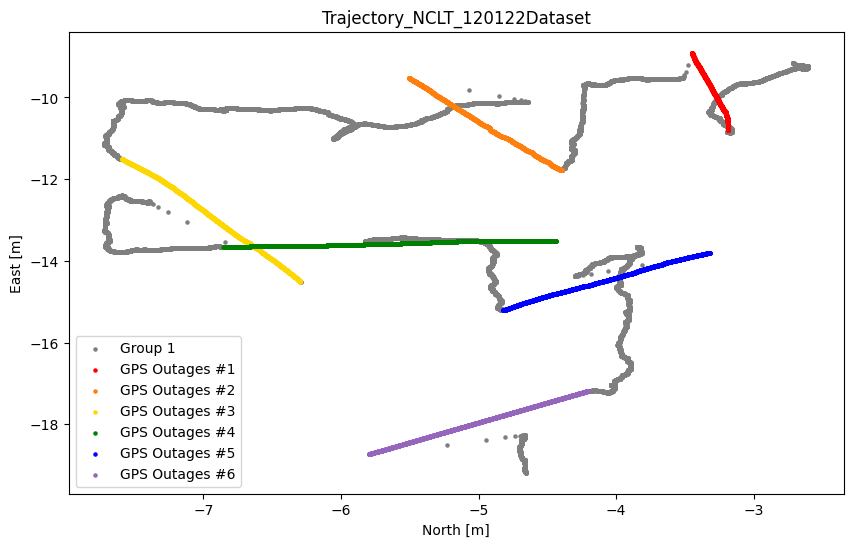

In [ ]:
df_GPS = pd.read_csv('/content/sample_data/position.csv', header = None, names = ['North', 'East', 'Down'])

df1 = df_GPS.iloc[50000:53020]
df2 = df_GPS.iloc[53020:56020]
df3 = df_GPS.iloc[56020:61020]
df4 = df_GPS.iloc[61020:64020]
df5 = df_GPS.iloc[64020:80020]
df6 = df_GPS.iloc[80020:83020]
df7 = df_GPS.iloc[83020:90020]
df8 = df_GPS.iloc[90020:93020]
df9 = df_GPS.iloc[93020:100020]
df10 = df_GPS.iloc[100020:103020]
df11 = df_GPS.iloc[103020:115020]
df12 = df_GPS.iloc[115020:118020]
df13 = df_GPS.iloc[118020:120000]

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='tab:gray', label='Group 1', s=5)
plt.scatter(df3['North'], df3['East'], color='tab:gray', s=5)
plt.scatter(df5['North'], df5['East'], color='tab:gray', s=5)
plt.scatter(df7['North'], df7['East'], color='tab:gray', s=5)
plt.scatter(df9['North'], df9['East'], color='tab:gray', s=5)
plt.scatter(df11['North'], df11['East'], color='tab:gray', s=5)
plt.scatter(df13['North'], df13['East'], color='tab:gray', s=5)

plt.scatter(df2['North'], df2['East'], color='red', label='GPS Outages #1', s=5)
plt.scatter(df4['North'], df4['East'], color='tab:orange', label='GPS Outages #2', s=5)
plt.scatter(df6['North'], df6['East'], color='gold', label='GPS Outages #3', s=5)
plt.scatter(df8['North'], df8['East'], color='g', label='GPS Outages #4', s=5)
plt.scatter(df10['North'], df10['East'], color='b', label='GPS Outages #5', s=5)
plt.scatter(df12['North'], df12['East'], color='tab:purple', label='GPS Outages #6', s=5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()


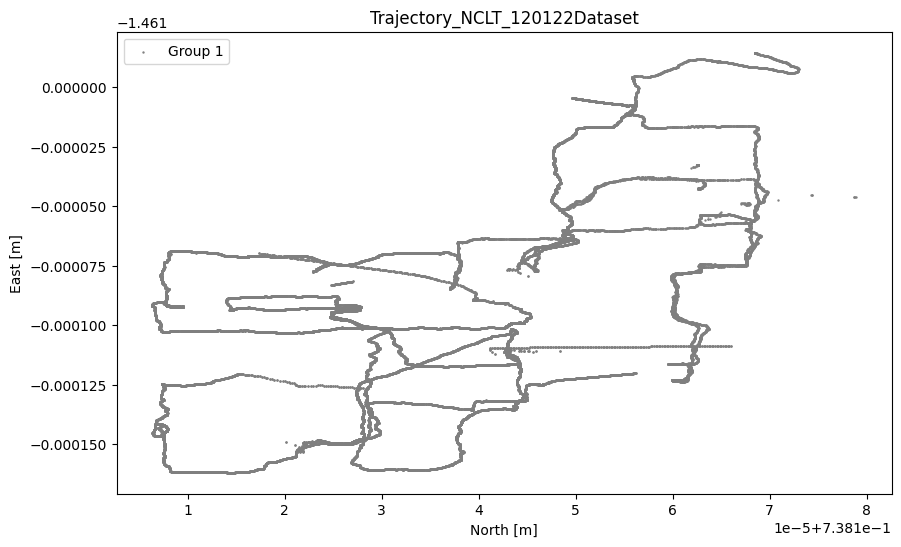

In [ ]:
df_GPS = pd.read_csv('/content/sample_data/120122_gps.csv', header = None, names = ['North', 'East', 'Down'], usecols=[3,4,5])

df1 = df_GPS

plt.figure(figsize=(10,6))
plt.scatter(df1['North'], df1['East'], color='tab:gray', label='Group 1', s=0.5)

plt.title('Trajectory_NCLT_120122Dataset')
plt.xlabel('North [m]')
plt.ylabel('East [m]')
plt.legend()
plt.show()
